**Importing the necessary modules**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import statsmodels.api as sm

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Assigning path
import os
import shutil
os.chdir("/content/drive/MyDrive/Nasscom/Final_Five")
print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1YlMLFzLEyPeRzVzPiY1QdXDP13IfS7N6/Nasscom/Final_Five


In [6]:
#Reading the CSV file
df=pd.read_csv('nizamabad_final.csv')

In [7]:
df.head()

,Date,Max_temp
0,2018-01-01,35.0
1,2018-01-02,36.2
2,2018-01-03,34.6
3,2018-01-04,34.7
4,2018-01-05,33.2


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1768 non-null   object 
 1   Max_temp  1768 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.8+ KB


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1768 non-null   datetime64[ns]
 1   Max_temp  1768 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.8 KB


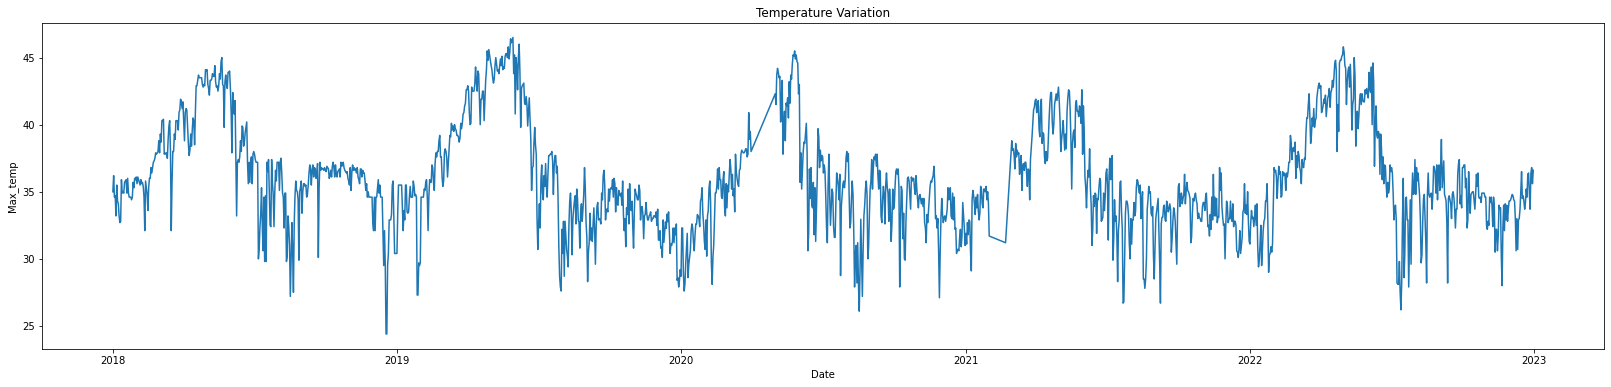

In [10]:
plt.figure(figsize=(28,6))
sns.lineplot(x=df['Date'], y=df['Max_temp'])
plt.title('Temperature Variation')
plt.show()


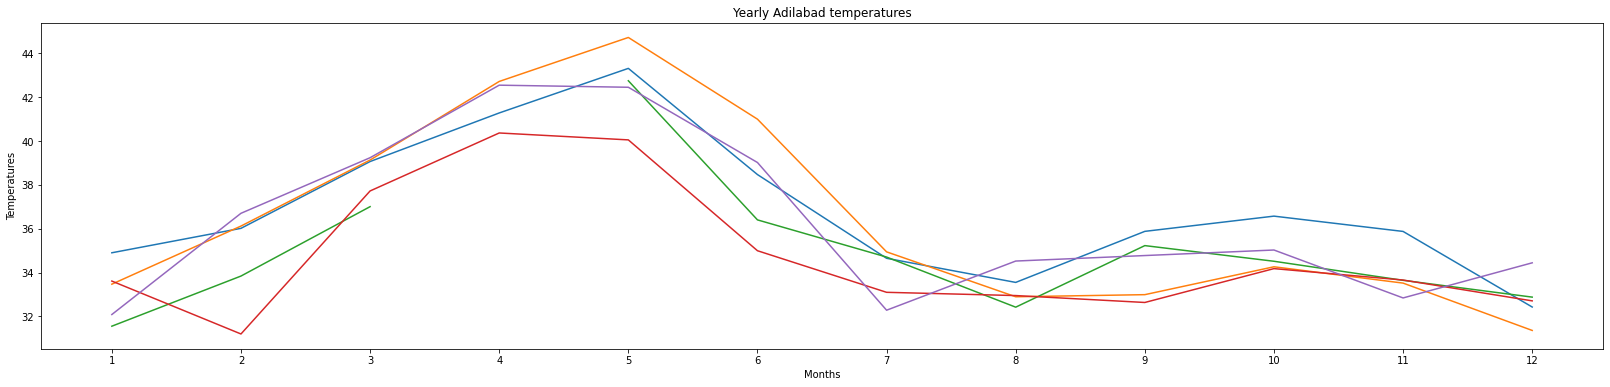

In [11]:
#Constructing a pivot table to see variation of temperatures on every month for every year
df['month']=df['Date'].dt.month
df['year']=df['Date'].dt.year
pivot = pd.pivot_table(df, values='Max_temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(28,6))
plt.title('Yearly Adilabad temperatures')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()


From the above pivot table, it is clearly visible that the temperature begins to rise in the beginning of march, peaks at the month of May and gradually reduces until September/October, and drastic reduce in the month of November, December and January. 

To visualize this in a much better way, let us see a mean of monthly temperatures of every year.

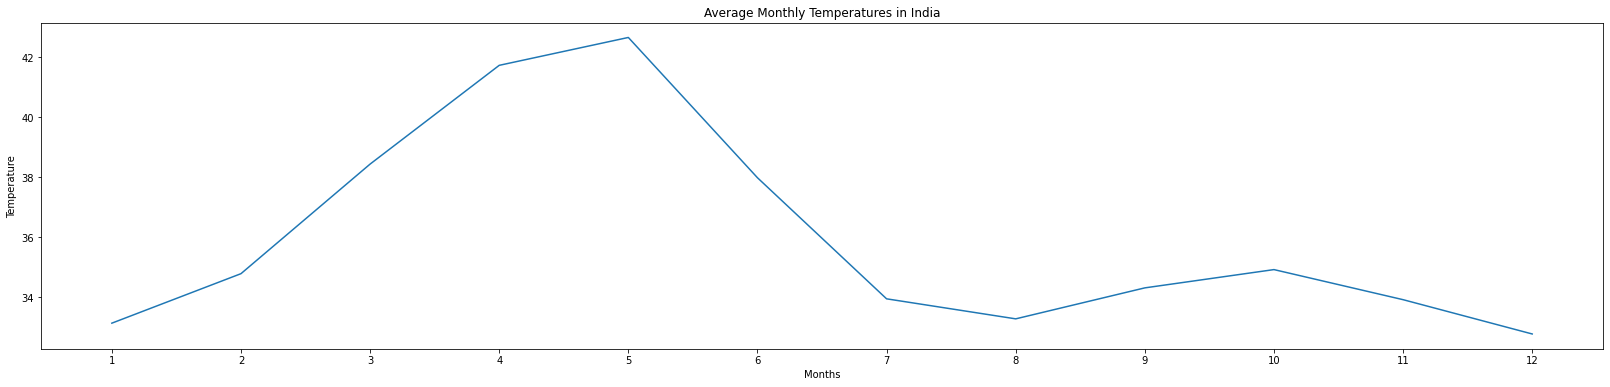

In [12]:
Average_monthly_Temperature = pivot.mean(axis=1)
Average_monthly_Temperature.plot(figsize=(28,6))
plt.title('Average Monthly Temperatures in India')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()


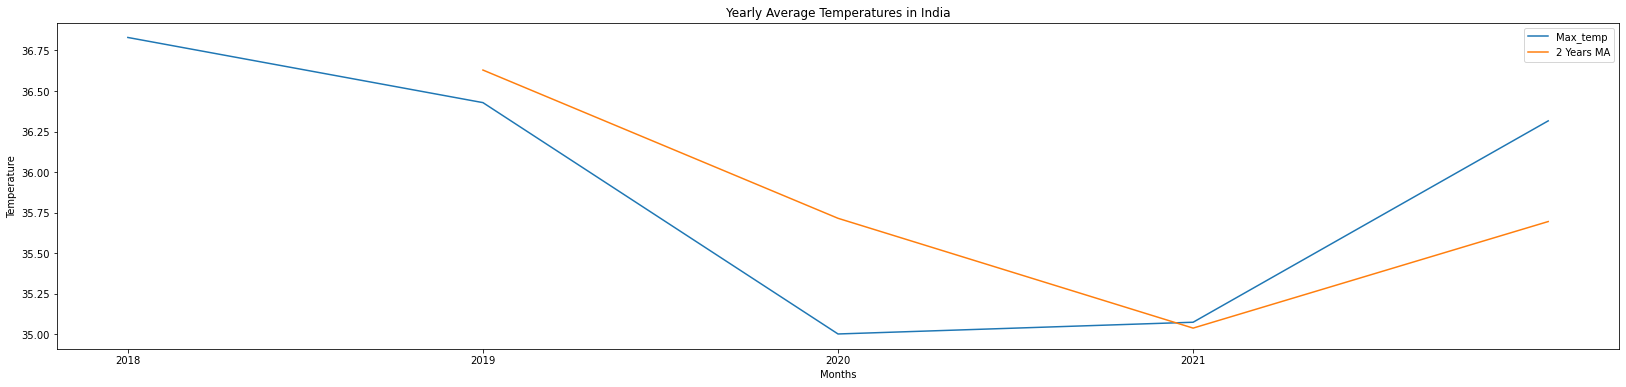

In [13]:
year_avg = pd.pivot_table(df, values='Max_temp', index='year', aggfunc='mean')
year_avg['2 Years MA'] = year_avg['Max_temp'].rolling(2).mean()
year_avg[['Max_temp','2 Years MA']].plot(figsize=(28,6))
plt.title('Yearly Average Temperatures in India')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(2018,2022)])
plt.show()


In [14]:
start_year_temp = year_avg.loc[2018, 'Max_temp']
end_year_temp = year_avg.loc[2022, 'Max_temp']
percentage_difference = ((end_year_temp - start_year_temp) / start_year_temp) * 100
print("The percentage Maximum Temperature difference between 2018 and 2022 is: ", percentage_difference,"%")

The percentage Maximum Temperature difference between 2018 and 2022 is:  -1.395542595292632 %


In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1768 non-null   datetime64[ns]
 1   Max_temp  1768 non-null   float64       
 2   month     1768 non-null   int64         
 3   year      1768 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 55.4 KB


In [17]:
df.reset_index(inplace=True)

In [44]:
df = df.drop(['index'], axis=1)

In [45]:
train = df[:-730].copy()
val = df[-730:-365].copy()
test = df[-365:].copy()

In [46]:
train

,Date,Max_temp,month,year
0,2018-01-01,35.0,1,2018
1,2018-01-02,36.2,1,2018
2,2018-01-03,34.6,1,2018
3,2018-01-04,34.7,1,2018
4,2018-01-05,33.2,1,2018
...,...,...,...,...
1033,2020-11-30,33.1,11,2020
1034,2020-12-01,34.5,12,2020
1035,2020-12-02,33.3,12,2020
1036,2020-12-03,32.7,12,2020


In [47]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Adilabad Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Results of Dickey-Fuller Test:
Test Statistic                   -3.4602
p-value                           0.0091
Lags Used                         6.0000
Number of Observations Used    1031.0000
Critical Value (1%)              -3.4367
Critical Value (5%)              -2.8643
Critical Value (10%)             -2.5683
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


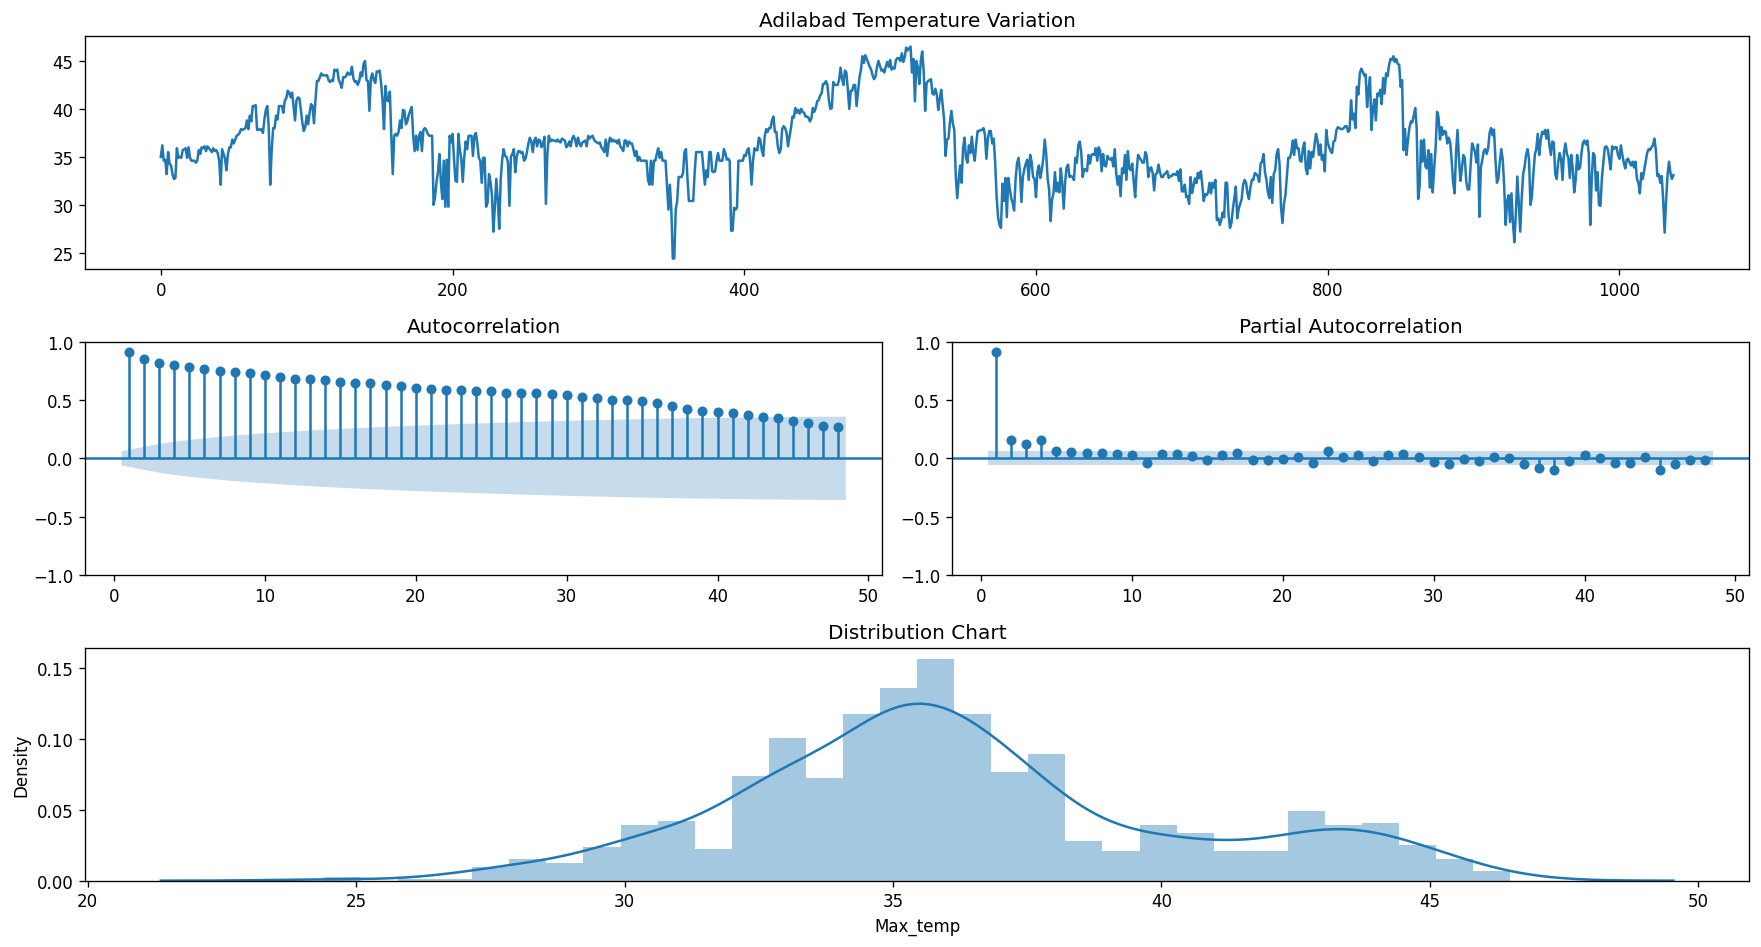

In [48]:
check_stationarity(train['Max_temp'])

In [21]:
train.set_index('Date',inplace=True)
test.set_index('Date',inplace=True)
val.set_index('Date',inplace=True)


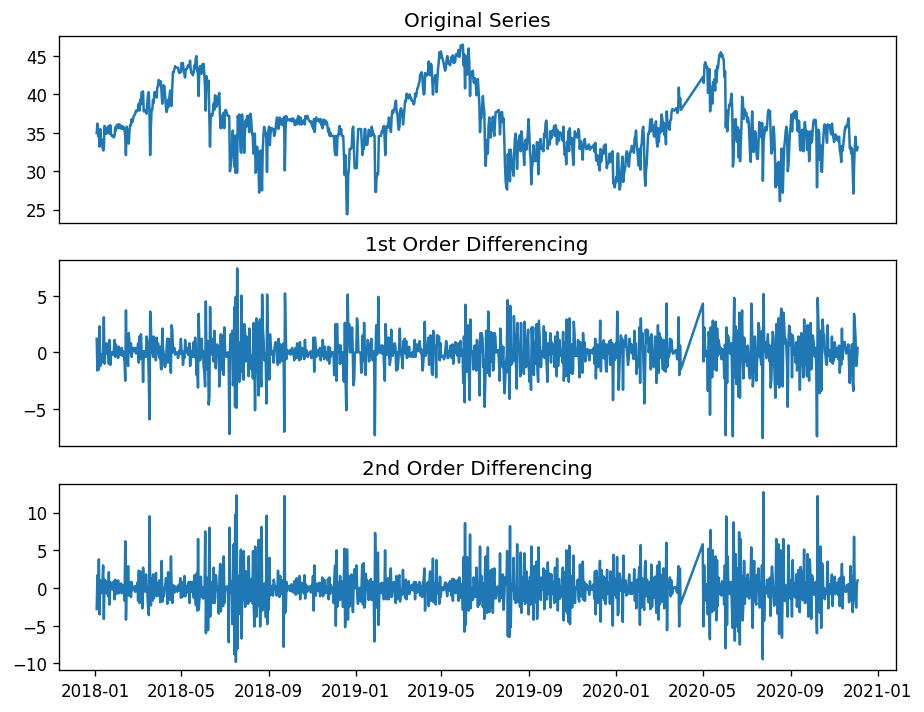

In [22]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(train["Max_temp"]); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train["Max_temp"].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train["Max_temp"].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

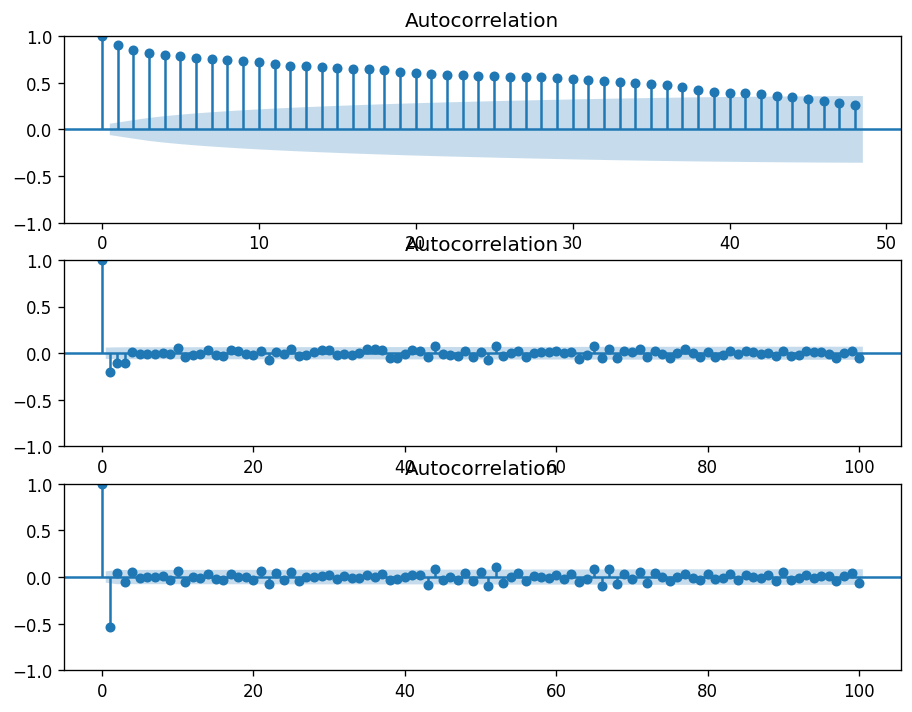

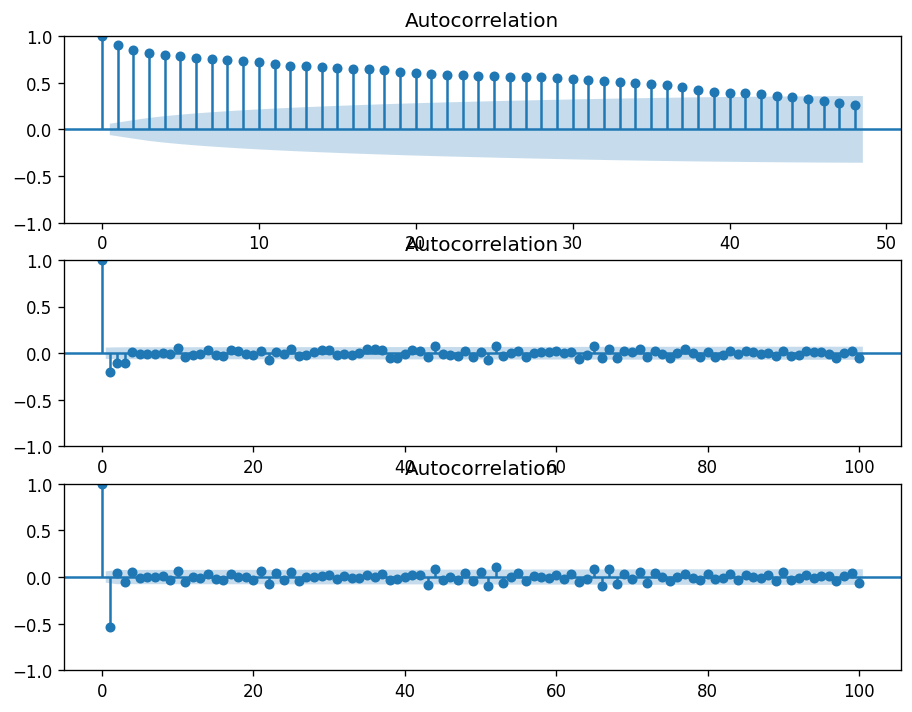

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf((train["Max_temp"]),lags=48, ax=ax1)
plot_acf((train["Max_temp"]).diff().dropna(), lags=100,ax=ax2)
plot_acf((train["Max_temp"]).diff().diff().dropna(),lags=100, ax=ax3)

In [24]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data on the training set
    pdq, PDQS, trend = params
    model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
    result = model.fit(disp=False)

    # Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction,result

In [26]:
val

,index,Max_temp,month,year
0,1038,33.2,12,2020
1,1039,32.8,12,2020
2,1040,33.2,12,2020
3,1041,33.7,12,2020
4,1042,35.3,12,2020
...,...,...,...,...
360,1398,34.0,12,2021
361,1399,33.3,12,2021
362,1400,35.0,12,2021
363,1401,32.8,12,2021


In [51]:
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

# Call the walk_forward function
val['Pred'],res = walk_forward(train['Max_temp'], val['Max_temp'], ((3,0,2),(1,1,1,12),'c'))
mape_pred = np.mean(np.abs((val['Max_temp'] - val['Pred']) / val['Max_temp'])) * 100
print(f"The MAPE of the SARIMA(2,0,1),(0,0,0,12),'t' model was {round(mape_pred,4)}%")



The MAPE of the SARIMA(2,0,1),(0,0,0,12),'t' model was 6.9836%


In [ ]:
train

,Max_temp,month,year
0,33.5,1,2018
1,33.2,1,2018
2,32.7,1,2018
3,32.2,1,2018
4,32.4,1,2018
...,...,...,...
1027,33.6,11,2020
1028,33.3,11,2020
1029,33.0,11,2020
1030,30.8,11,2020


In [ ]:
rmse_pred = sqrt(mean_squared_error(val['Max_temp'],val['Pred']))
print(f"The RMSE of the SARIMA(3,1,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} celsius degrees")

The RMSE of the SARIMA(3,1,0),(0,1,1,12),'c' model was 3.9014 celsius degrees


In [52]:
val['Error'] = val['Max_temp'] - val['Pred']

In [53]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,1:3])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [54]:
val.drop(['month','year'], axis=1, inplace=True)
val.head()

,Date,Max_temp,Pred,Error
0,2020-12-05,33.2,33.275489,-0.075489
1,2020-12-06,32.8,33.258859,-0.458859
2,2020-12-07,33.2,32.859060,0.340940
3,2020-12-08,33.7,32.668198,1.031802
4,2020-12-09,35.3,33.015477,2.284523


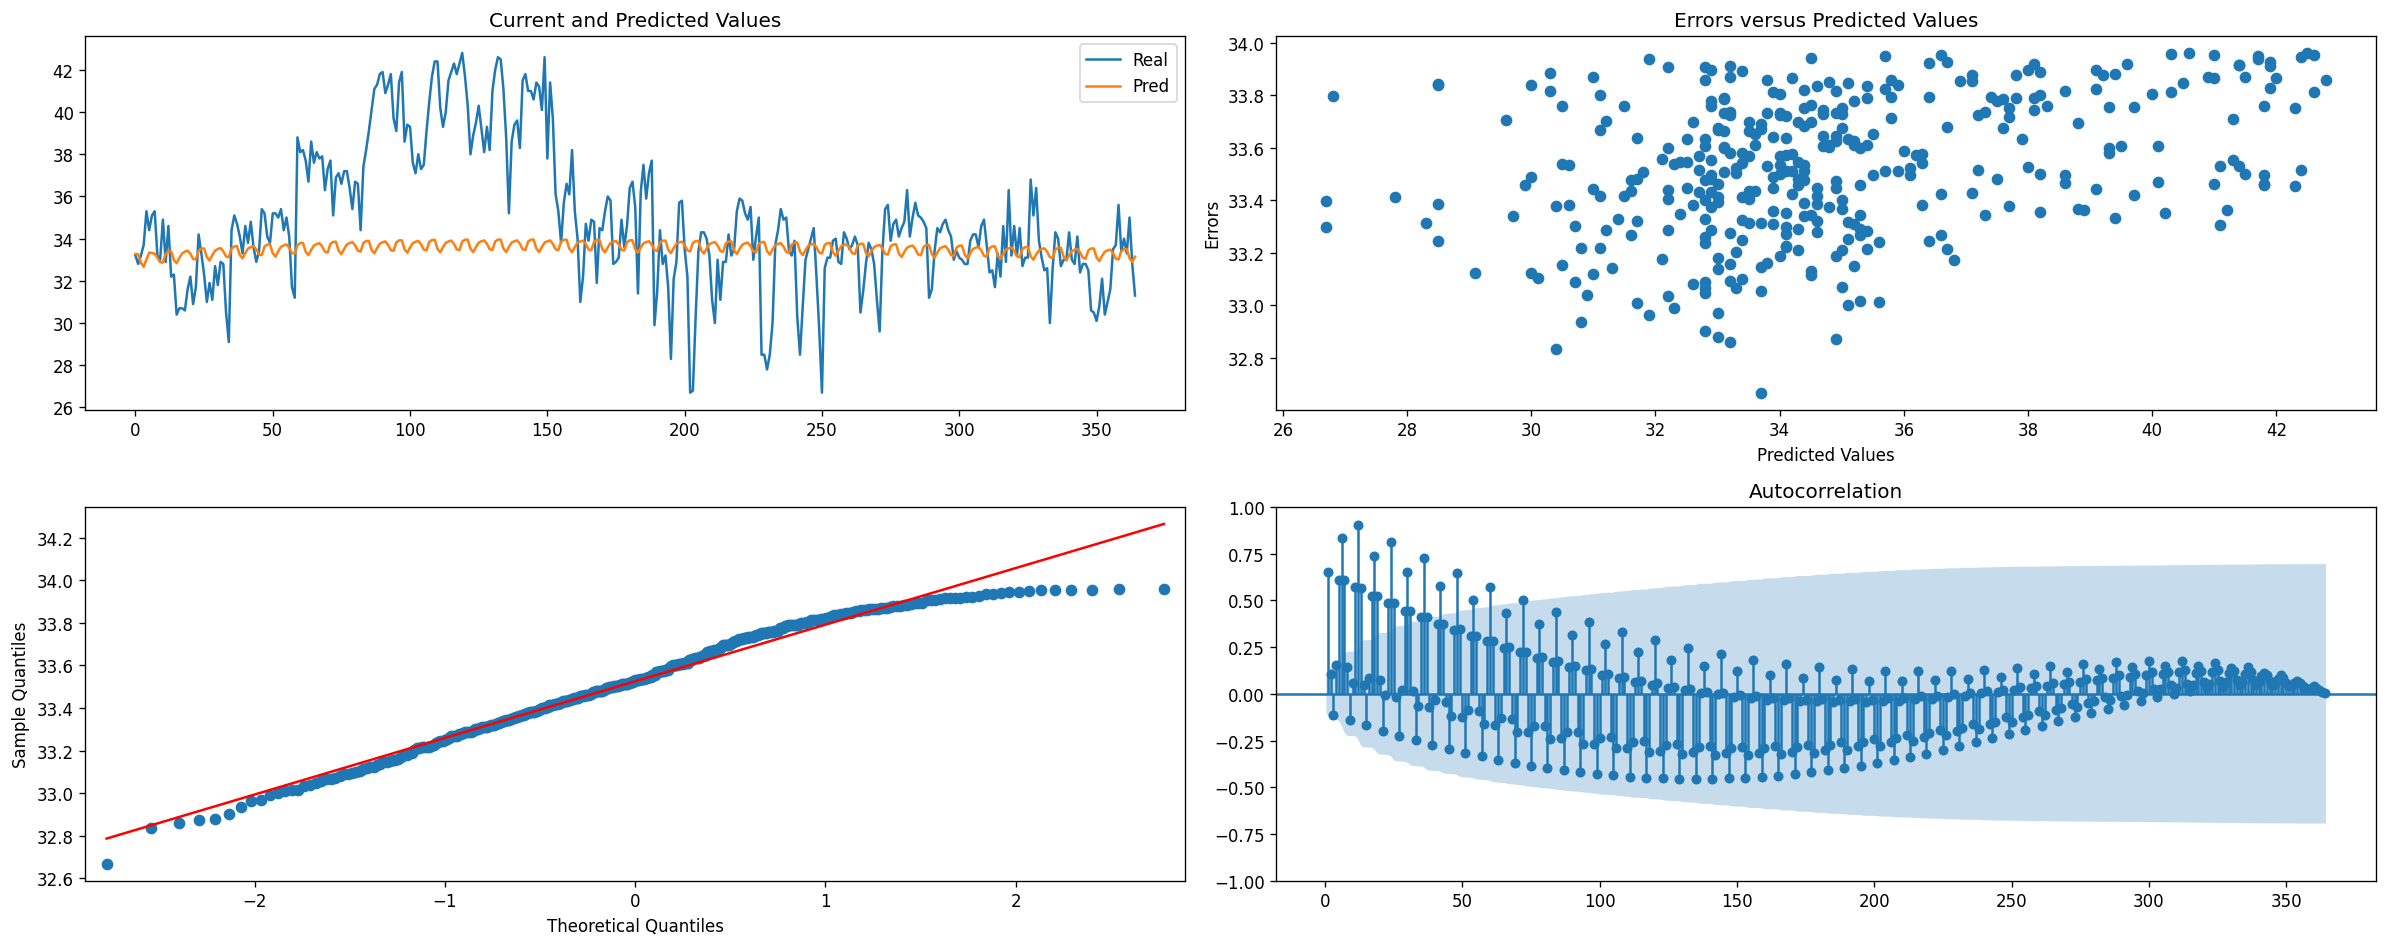

In [55]:
plot_error(val)

In [56]:
future = pd.concat([train, val])
future.head()

,Date,Max_temp,month,year,Pred,Error
0,2018-01-01,35.0,1.0,2018.0,NaN,NaN
1,2018-01-02,36.2,1.0,2018.0,NaN,NaN
2,2018-01-03,34.6,1.0,2018.0,NaN,NaN
3,2018-01-04,34.7,1.0,2018.0,NaN,NaN
4,2018-01-05,33.2,1.0,2018.0,NaN,NaN


In [57]:
drps = ['month', 'Pred', 'Error', 'year']
future = future.drop(drps, axis=1)

In [50]:
future

,Date,Max_temp,month,year
0,2018-01-01,35.0,1,2018
1,2018-01-02,36.2,1,2018
2,2018-01-03,34.6,1,2018
3,2018-01-04,34.7,1,2018
4,2018-01-05,33.2,1,2018
...,...,...,...,...
1398,2021-12-27,34.0,12,2021
1399,2021-12-28,33.3,12,2021
1400,2021-12-29,35.0,12,2021
1401,2021-12-30,32.8,12,2021


In [58]:
future.set_index('Date')

,Max_temp
Date,
2018-01-01,35.0
2018-01-02,36.2
2018-01-03,34.6
2018-01-04,34.7
2018-01-05,33.2
...,...
2021-12-27,34.0
2021-12-28,33.3
2021-12-29,35.0


In [59]:
model = sm.tsa.statespace.SARIMAX(future.Max_temp, order=(3,0,2), seasonal_order=(1,1,1,12), trend='c')
result = model.fit(disp=False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
forecast_periods = 26
pred = result.get_prediction(start=len(future), end=len(future)+forecast_periods-1, dynamic=True)
test['Pred'] = pred.predicted_mean

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [61]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+365))
test['Pred']

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1403    31.920914
1404    32.323418
1405    32.422607
1406    32.534681
1407    32.058074
          ...    
1763    30.606261
1764    30.568544
1765    30.619952
1766    30.535816
1767    30.123295
Name: Pred, Length: 365, dtype: float64

In [62]:
test.set_index('Date', inplace=True)

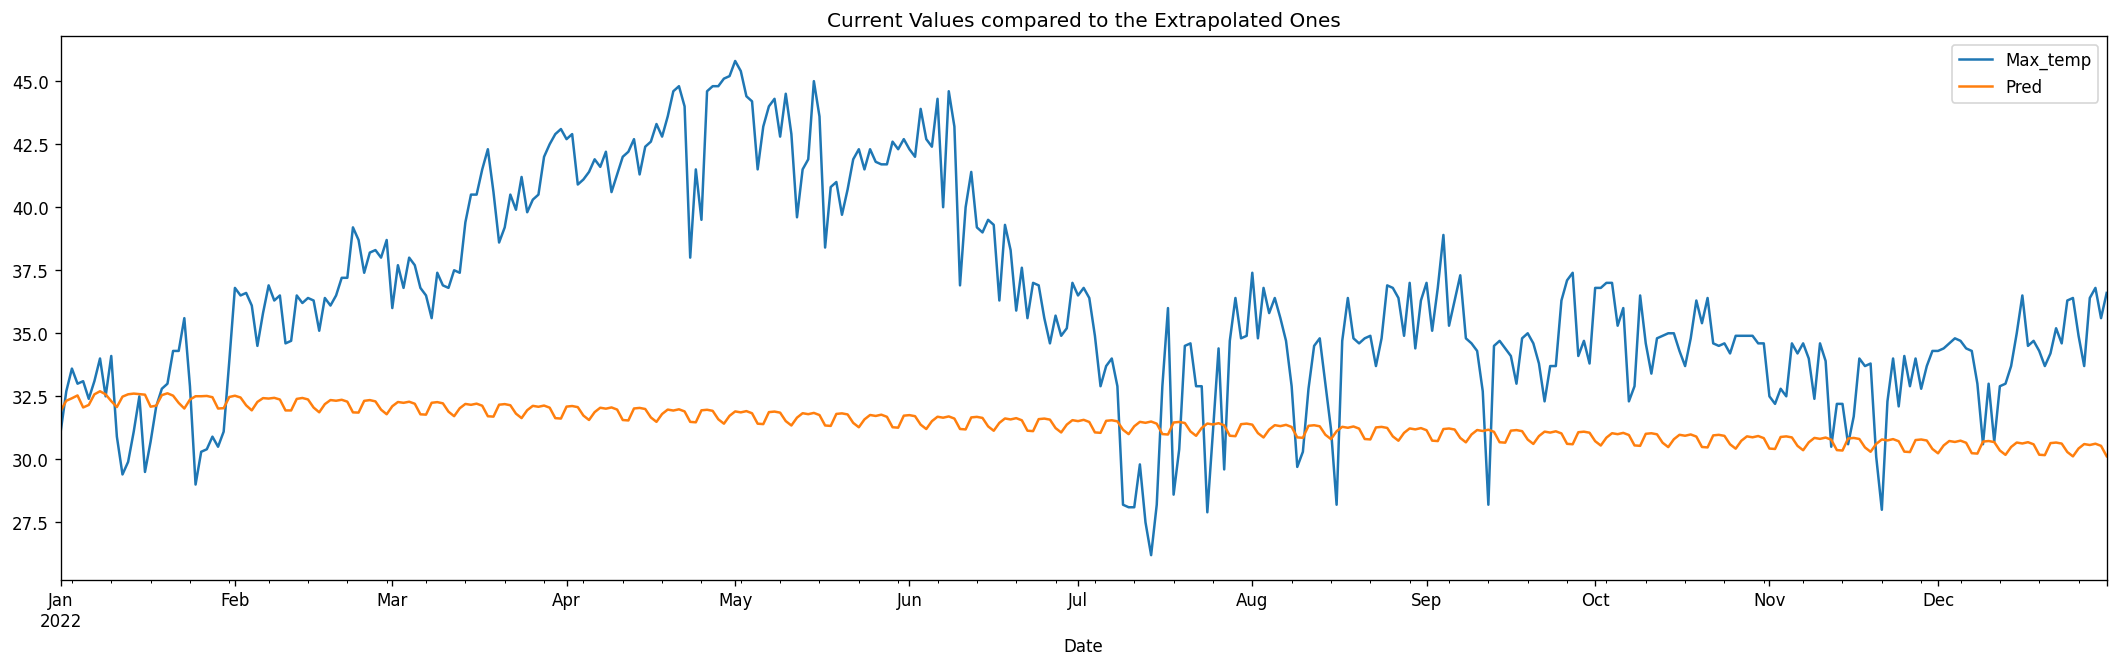

In [63]:
test[['Max_temp', 'Pred']].plot(figsize=(22,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

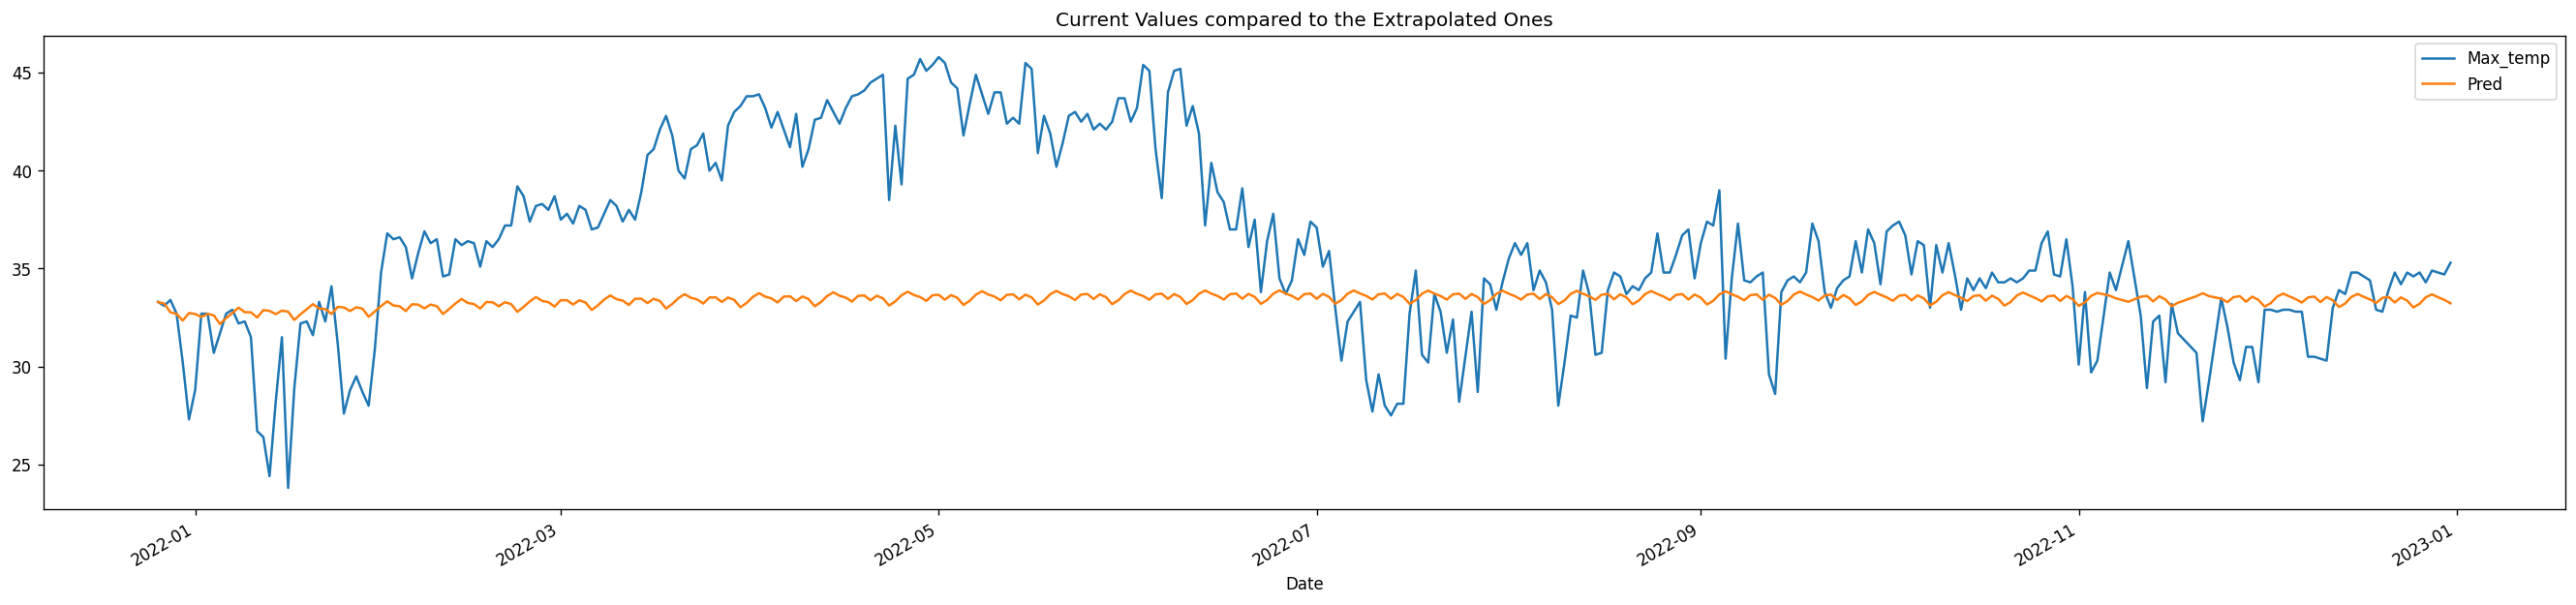

In [ ]:
test[['Max_temp', 'Pred']].plot(figsize=(28,6))
plt.title('Current Values compared to the Extrapolated Ones')
plt.show()

In [64]:
pdq = (3, 0, 2)
PDQS = (1, 1, 1, 12)
trend = 'c'
params = (pdq, PDQS, trend)

# Define a new dataset for the year 2023
dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
new_data = pd.DataFrame(index=dates_2023, columns=['Max_temp'])

# Generate predictions for the year 2023
predictions,adil_model = walk_forward(df['Max_temp'], new_data['Max_temp'], params)

# Add the predictions to the new dataset
new_data['Max_temp'] = predictions

In [65]:
final_month = new_data.resample('M').mean()

final_month['month'] = final_month.index.month_name()

final_month = final_month.reset_index(drop=True)

final_month = final_month[['month', 'Max_temp']]

In [68]:
final_month_list = final_month.values.tolist()

In [69]:
final_month_list

[['January', 35.762470292324736],
 ['February', 35.53308270684371],
 ['March', 35.35399813671122],
 ['April', 35.25236345877777],
 ['May', 35.16283089192487],
 ['June', 35.10065855108332],
 ['July', 35.05655594169566],
 ['August', 35.01010495760978],
 ['September', 34.972054352416286],
 ['October', 34.94229813984692],
 ['November', 34.90775677213778],
 ['December', 34.875183811328]]

In [67]:
import pickle
with open('nizamabad_hp.pkl', 'wb') as f:
    pickle.dump(adil_model, f)